<a href="https://colab.research.google.com/github/steliosg23/TextAnalytics-DS-2025/blob/main/TA_Assignment_1_N_grams_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3

(i) Implement a bigram and a trigram language model for sentences, using Laplace smoothing or optionally Kneser- Ney smoothing.

In practice, n-gram language models
compute the sum of the logarithms of the n-gram probabilities of each sequence, instead of
their product and you should do the same.

Assume that each sentence starts with the
pseudo-token *start* (or two pseudo-tokens *start1*, *start2* for the trigram model) and
ends with the pseudo-token *end*.

Train your models on a training subset of a corpus. Include in the vocabulary
only words that occur, e.g., at least 10 times in the training subset. Use the same vocabulary
in the bigram and trigram models. Replace all out-of-vocabulary (OOV) words (in the
training, development, test subsets) by a special token *UNK*.

Alternatively, use BPEs instead of words (obtaining the BPE vocabulary from your training subset) to
avoid unknown words.

In [1]:
!pip install -U nltk

In [2]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Downloading the Reuters corpus from NLTK library.

In [3]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

## Loading the corpus

stelios


In [4]:


import re
import math
import random
import unicodedata
import string
from collections import Counter
# numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading and Processing the Reuters Corpus

### 1. Importing the Reuters Corpus
We begin by importing the Reuters corpus from the `nltk` library:



In [5]:
from nltk.corpus import gutenberg

# Load the Reuters corpus
reuters_corpus = gutenberg.fileids()

# Print the first 10 files
print(reuters_corpus[:10])


['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt']


### 2. Constructing the Final Corpus
We then iterate through each file in the corpus, convert its text to lowercase, and append it to a string that will contain the entire corpus.

In [6]:
# Initialize an empty string to store the final corpus
final_corpus = ''

# Loop through each file in the Reuters corpus
for corpus in reuters_corpus:
    # Load the raw text from the file
    text = gutenberg.raw(fileids=corpus)

    # Convert the text to lowercase
    lower_text = text.lower()

    # Add the lowercase text to the final corpus
    final_corpus += lower_text

# Print the total number of words in the final corpus
print(len(final_corpus.split()))

2135242


## Text Cleaning Function

The `text_cleaning` function is designed to clean the input text by removing unwanted characters, keeping only words and sentence-ending punctuation marks (periods, question marks, exclamation points, and apostrophes). It also removes multiple spaces and newline characters.

In [7]:
import re

def text_cleaning(text):

    # Remove all characters except letters (both uppercase and lowercase),
    # sentence-ending characters (periods, question marks, exclamation marks),
    # and apostrophes. Replace unwanted characters with a space.
    corpus = re.sub(r'[^a-zA-Z.?!\']', ' ', text)

    # Remove all left square brackets '[' from the text
    corpus = corpus.replace('[', '')

    # Replace all right square brackets ']' with a period '.'
    corpus = corpus.replace(']', '.')

    # Remove specific special characters (like $, @, ^, &, *, (, ), €, :, etc.)
    # by replacing them with a space.
    corpus = re.sub(r'[[]/$@^&*()€:΄,]', ' ', corpus)

    # Replace multiple consecutive spaces with a single space
    corpus = re.sub(' +', ' ', corpus)

    # Replace newline characters '\n' with a space to maintain continuous text
    corpus = corpus.replace('\n', ' ')

    # Return the cleaned text
    return corpus


In [8]:
# Print the first 150 characters of the corpus before cleaning
print(f'Before Cleaning: {final_corpus[:150]}...\n')

# Clean the corpus
final_corpus = text_cleaning(final_corpus)

# Print the first 150 characters of the corpus after cleaning
print(f'After Cleaning: {final_corpus[:150]}...')


Before Cleaning: [emma by jane austen 1816]

volume i

chapter i


emma woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to...



<ipython-input-7-582df6af6b3e>:18: FutureWarning: Possible nested set at position 1
  corpus = re.sub(r'[[]/$@^&*()€:΄,]', ' ', corpus)


After Cleaning:  emma by jane austen volume i chapter i emma woodhouse handsome clever and rich with a comfortable home and happy disposition seemed to unite some of ...


In [9]:
import nltk

def sentence_tokenization(text):
    try:
        # Tokenizes the input text into a list of sentences using NLTK's sent_tokenize
        return nltk.sent_tokenize(text)
    except Exception as e:
        # Handle any errors that occur during sentence tokenization
        print(f"Error in tokenizing text: {e}")
        return []


In [10]:
sentence_list = sentence_tokenization(final_corpus)

# Print the first three sentences of the corpus
for i in range(10):
    print(f"Sentence {i+1}: {sentence_list[i]}")


Sentence 1:  emma by jane austen volume i chapter i emma woodhouse handsome clever and rich with a comfortable home and happy disposition seemed to unite some of the best blessings of existence and had lived nearly twenty one years in the world with very little to distress or vex her.
Sentence 2: she was the youngest of the two daughters of a most affectionate indulgent father and had in consequence of her sister's marriage been mistress of his house from a very early period.
Sentence 3: her mother had died too long ago for her to have more than an indistinct remembrance of her caresses and her place had been supplied by an excellent woman as governess who had fallen little short of a mother in affection.
Sentence 4: sixteen years had miss taylor been in mr. woodhouse's family less as a governess than a friend very fond of both daughters but particularly of emma.
Sentence 5: between them it was more the intimacy of sisters.
Sentence 6: even before miss taylor had ceased to hold the nom

## Word Tokenization Function

The `word_tokenization` function takes an input text and tokenizes it into a list of words using the NLTK library's `word_tokenize` function. It also handles any exceptions that may occur during the tokenization process.

In [11]:
import nltk

def word_tokenization(text):
    try:
        # Tokenizes the input text into a list of words using NLTK's word_tokenize
        return nltk.word_tokenize(text)
    except Exception as e:
        # Handle any errors that occur during word tokenization
        print(f"Error in tokenizing text: {e}")
        return []


In [12]:
# Apply word_tokenization for each sentence in the sentence list
words_in_sentences = [word_tokenization(sentence) for sentence in sentence_list]

# Print words for the first three sentences in the corpus
for i in range(10):
    print(f"Sentence {i+1}: {words_in_sentences[i]}")


Sentence 1: ['emma', 'by', 'jane', 'austen', 'volume', 'i', 'chapter', 'i', 'emma', 'woodhouse', 'handsome', 'clever', 'and', 'rich', 'with', 'a', 'comfortable', 'home', 'and', 'happy', 'disposition', 'seemed', 'to', 'unite', 'some', 'of', 'the', 'best', 'blessings', 'of', 'existence', 'and', 'had', 'lived', 'nearly', 'twenty', 'one', 'years', 'in', 'the', 'world', 'with', 'very', 'little', 'to', 'distress', 'or', 'vex', 'her', '.']
Sentence 2: ['she', 'was', 'the', 'youngest', 'of', 'the', 'two', 'daughters', 'of', 'a', 'most', 'affectionate', 'indulgent', 'father', 'and', 'had', 'in', 'consequence', 'of', 'her', 'sister', "'s", 'marriage', 'been', 'mistress', 'of', 'his', 'house', 'from', 'a', 'very', 'early', 'period', '.']
Sentence 3: ['her', 'mother', 'had', 'died', 'too', 'long', 'ago', 'for', 'her', 'to', 'have', 'more', 'than', 'an', 'indistinct', 'remembrance', 'of', 'her', 'caresses', 'and', 'her', 'place', 'had', 'been', 'supplied', 'by', 'an', 'excellent', 'woman', 'as', 'g

## Data Splitting Process

In this process, the corpus is split into three subsets: `train_corpus`, `dev_corpus`, and `test_corpus`. This is a common practice in machine learning for training, development, and testing models.

### Steps:
1. **Set Random Seed for Reproducibility:**
   The random seed is set to ensure that the splitting process is reproducible. This means that every time the code runs, the same splits will occur, providing consistency in results.

2. **Initial Split into Train and Temporary Corpus:**
   The corpus is first split into two sets: the `train_corpus` and a `temp_corpus` which contains 40% of the data. The remaining 60% is used for training. This ensures that a portion of the data is available for training the model.

3. **Further Split the Temporary Corpus into Dev and Test Sets:**
   The `temp_corpus` (which is 40% of the original corpus) is further split evenly into two parts: the `dev_corpus` (development set) and the `test_corpus` (test set). Each of these subsets will contain 20% of the original corpus. The dev set is used for model tuning, and the test set is kept for evaluating the model's final performance.

4. **Resulting Subsets:**
   After the splits, you have:
   - `train_corpus` containing 60% of the data used for training.
   - `dev_corpus` containing 20% of the data used for validation and hyperparameter tuning.
   - `test_corpus` containing 20% of the data used for final testing.

This splitting process helps in ensuring that the model is trained, validated, and tested on separate data sets to avoid overfitting and ensure robust evaluation.


In [13]:
from sklearn.model_selection import train_test_split

# Shuffle and split the corpus into train, dev, and test sets
train_corpus, temp_corpus = train_test_split(words_in_sentences, test_size=0.4, random_state=2025)

# Further split temp_corpus into dev and test sets
dev_corpus, test_corpus = train_test_split(temp_corpus, test_size=0.5, random_state=2025)



In [14]:
# Print a sample of each set
print("Sample from Training Set:")
print(train_corpus[:3])  # Printing the first 3 samples from the training set

print("\nSample from Development Set:")
print(dev_corpus[:3])  # Printing the first 3 samples from the development set

print("\nSample from Test Set:")
print(test_corpus[:3])  # Printing the first 3 samples from the test set


Sample from Training Set:
[['and', 'they', 'all', 'condemned', 'him', 'to', 'be', 'guilty', 'of', 'death', '.'], ['yes', 'in', 'a', 'real', 'sense', 'nature', 'does', 'not', 'exist', '.'], ['human', 'science', 'can', 'never', 'be', 'quite', 'certain', 'of', 'things', 'like', 'that', 'said', 'father', 'brown', 'still', 'looking', 'at', 'the', 'red', 'budding', 'of', 'the', 'branches', 'over', 'his', 'head', 'if', 'only', 'because', 'of', 'the', 'difficulty', 'about', 'definition', 'and', 'connotation', '.']]

Sample from Development Set:
[['violet', '.'], ['it', 'is', 'things', 'going', 'right', 'he', 'cried', 'that', 'is', 'poetical', 'i', 'our', 'digestions', 'for', 'instance', 'going', 'sacredly', 'and', 'silently', 'right', 'that', 'is', 'the', 'foundation', 'of', 'all', 'poetry', '.'], ['i', 'wo', "n't", 'detain', 'you', '.']]

Sample from Test Set:
[['though', 'while', 'he', 'lived', 'he', 'blessed', 'his', 'soul', 'and', 'men', 'will', 'praise', 'thee', 'when', 'thou', 'doest', '

## N-gram Calculation with Kneser-Ney Smoothing

The following functions are used to calculate n-grams (unigrams, bigrams, trigrams, etc.) from a given corpus. Kneser-Ney smoothing is applied to bigrams and higher-order n-grams to improve the model's performance by adjusting for zero-frequency events.

### Functions:

1. **`calc_ngrams(corpus, n)`**:
   - **Purpose:** This function calculates n-grams (where `n` is the number of items in the n-gram) with Kneser-Ney smoothing.
   - **How It Works:**
     - It creates `n`-grams for each sentence in the corpus and updates a counter to track the frequency of each n-gram.
     - It also generates (n-1)-grams for lower-order smoothing.
     - If the `n`-grams are bigrams or higher, Kneser-Ney smoothing is applied by adjusting the frequency of n-grams based on the lower-order (n-1)-grams.
   - **Return:** A `Counter` object containing the smoothed n-grams.

2. **`calc_unigrams(corpus)`**:
   - **Purpose:** This function calculates unigrams (single words) from the corpus.
   - **How It Works:** It creates unigrams for each sentence in the corpus and counts their occurrences.
   - **Return:** A `Counter` object containing the unigrams. No smoothing is applied here because Kneser-Ney smoothing typically applies to bigrams or higher.

3. **`calc_bigrams(corpus)`**:
   - **Purpose:** This function calculates bigrams (pairs of consecutive words) from the corpus, using the `calc_ngrams` function with `n=2`.
   - **Return:** A `Counter` object containing the smoothed bigrams.

4. **`calc_trigrams(corpus)`**:
   - **Purpose:** This function calculates trigrams (triplets of consecutive words) from the corpus, using the `calc_ngrams` function with `n=3`.
   - **Return:** A `Counter` object containing the smoothed trigrams.




In [15]:
import math
from collections import Counter
from nltk.util import ngrams
from tqdm import tqdm

from collections import Counter
from nltk.util import ngrams
from tqdm import tqdm

def calc_ngrams(corpus, n):
    """ Returns a Counter for n-grams (unigrams, bigrams, trigrams, etc.) without smoothing and log-probabilities. """
    ngram_counter = Counter()

    # Generate n-grams for each sentence with a progress bar
    for sentence in tqdm(corpus, desc=f"Processing {n}-grams", unit="sentence"):
        if n == 3:
            # For trigrams, use two start tokens ("<s1>", "<s2>")
            sentence_ngrams = list(ngrams(sentence, n, pad_left=True, pad_right=True, left_pad_symbol='<s1>', right_pad_symbol='<e>'))
            # Replace the first two padding symbols for trigrams (<s1>, <s1>) with (<s1>, <s2>)
            sentence_ngrams = [(('<s1>', '<s2>') if gram[:2] == ('<s1>', '<s1>') else gram) for gram in sentence_ngrams]
        else:
            # For other n-grams, use a single start token ("<s>")
            sentence_ngrams = list(ngrams(sentence, n, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='<e>'))

        ngram_counter.update(sentence_ngrams)

    # Return the n-gram counts without smoothing or log-probabilities
    return ngram_counter

def calc_unigrams(corpus):
    # Returns a Unigram Counter with Kneser-Ney smoothing.
    unigram_counter = Counter()
    for sentence in corpus:
        unigram_counter.update(ngrams(sentence, 1, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='<e>'))

    # For unigrams, no smoothing is applied in Kneser-Ney (this is typically for bigrams or higher)
    return unigram_counter

def calc_bigrams(corpus):
    # Returns a Bigram Counter with Kneser-Ney smoothing.
    return calc_ngrams(corpus, 2)

def calc_trigrams(corpus):
    # Returns a Trigram Counter with Kneser-Ney smoothing.
    return calc_ngrams(corpus, 3)


## Replacing Out-of-Vocabulary (OOV) Words in Training Corpus

The `replace_oov_words_train` function identifies and replaces out-of-vocabulary (OOV) words in a training corpus. It also creates a vocabulary by excluding the OOV words and returning them separately.

### Steps:

1. **Calculate Unigram Counts:**
   - The function starts by calculating the unigram (single word) counts for the entire corpus using the `calc_unigrams` function. This gives the frequency of each word in the corpus.

2. **Identify OOV Words:**
   - OOV words are those whose frequency in the corpus is less than a predefined threshold (in this case, less than 10 occurrences).
   - The function creates a dictionary where OOV words are mapped to the placeholder `'UNK'`.

3. **Replace OOV Words in the Corpus:**
   - The function processes each sentence in the corpus and replaces any OOV word with `'UNK'`. Words that are not OOV are left unchanged.

4. **Create Vocabulary:**
   - The vocabulary is created by including only those words from the unigram counts that are not considered OOV. The resulting vocabulary excludes the rare words that have been replaced with `'UNK'`.

5. **Return Results:**
   - The function returns:
     - A dictionary of OOV words, where each OOV word is replaced by `'UNK'`.
     - The cleaned corpus where OOV words have been replaced with `'UNK'`.
     - The vocabulary, which contains all the words that are not considered OOV.

### Purpose:
The function is useful in preparing a training corpus for language models by replacing rare or unseen words (OOV) with a special token (`'UNK'`). This ensures that the model doesn't encounter issues when faced with words that were not present in the training set. It also creates a vocabulary that helps in efficient processing and model training by excluding rare words.


## Why We Do the Same

- **Numerical Stability**: Multiplying many small probabilities can cause underflow. Taking the log of probabilities ensures that we avoid this issue.
- **Simplification**: Adding logarithms is computationally simpler and more stable than multiplying probabilities.
- **Optimization**: The log-likelihood function is easier to maximize compared to the product of probabilities.
- **Consistency**: Using log-probabilities is the standard approach in machine learning and natural language processing, ensuring consistency with other models and libraries.

In summary, computing the sum of the logarithms of the n-gram probabilities instead of directly multiplying the probabilities is a widely adopted practice for maintaining numerical stability and simplifying the optimization process in language models.



In [16]:
def replace_oov_words_train(corpus):

    # Calculate unigram frequencies for the corpus
    unigram_counter = calc_unigrams(corpus)

    # Create a dictionary for OOV words (those that appear less than 10 times)
    OOV_words = {k[0]: "UNK" for k, v in unigram_counter.items() if v < 10}

    # Replace OOV words in the corpus (using list comprehension for each sentence)
    clean_corpus = [
        [OOV_words.get(word, word) for word in sentence]
        for sentence in corpus
    ]

    # Create vocabulary (set of unique words not in OOV_words)
    vocabulary = [f[0] for f in unigram_counter.keys() if f[0] not in OOV_words]
    vocabulary = set(vocabulary)  # Set for unique words

    return OOV_words, clean_corpus, vocabulary

# Example usage:
oov_words, final_train_corpus, vocabulary = replace_oov_words_train(train_corpus)


In [17]:
def replace_oov_words_dev_test(corpus, vocabulary, oov_words):
    # Define a helper function to replace OOV words in a sentence
    def replace_in_sentence(sentence):
        return [
            'UNK' if word not in vocabulary or word in oov_words else word
            for word in sentence
        ]

    # Apply the replacement to the entire corpus using list comprehension
    clean_corpus = list(map(replace_in_sentence, corpus))

    return clean_corpus

# Example usage:
final_dev_corpus = replace_oov_words_dev_test(dev_corpus, vocabulary, oov_words)
final_test_corpus = replace_oov_words_dev_test(test_corpus, vocabulary, oov_words)


In [18]:
# Function to print samples from the final corpus
def print_samples(corpus, num_samples=5):
    """ Print a few sample sentences from the corpus """
    for i, sentence in enumerate(corpus[:num_samples]):
        print(f"Sample {i+1}: {sentence}")

# Print samples from final_dev_corpus and final_test_corpus
print("Samples from final_dev_corpus:")
print_samples(final_dev_corpus)

print("\nSamples from final_test_corpus:")
print_samples(final_test_corpus)


Samples from final_dev_corpus:
Sample 1: ['violet', '.']
Sample 2: ['it', 'is', 'things', 'going', 'right', 'he', 'cried', 'that', 'is', 'poetical', 'i', 'our', 'UNK', 'for', 'instance', 'going', 'UNK', 'and', 'silently', 'right', 'that', 'is', 'the', 'foundation', 'of', 'all', 'poetry', '.']
Sample 3: ['i', 'wo', "n't", 'detain', 'you', '.']
Sample 4: ['for', 'ye', 'suffer', 'if', 'a', 'man', 'bring', 'you', 'into', 'bondage', 'if', 'a', 'man', 'devour', 'you', 'if', 'a', 'man', 'take', 'of', 'you', 'if', 'a', 'man', 'exalt', 'himself', 'if', 'a', 'man', 'smite', 'you', 'on', 'the', 'face', '.']
Sample 5: ['cape', 'of', 'good', 'hope', 'do', 'they', 'call', 'ye', '?']

Samples from final_test_corpus:
Sample 1: ['though', 'while', 'he', 'lived', 'he', 'blessed', 'his', 'soul', 'and', 'men', 'will', 'praise', 'thee', 'when', 'thou', 'doest', 'well', 'to', 'thyself', '.']
Sample 2: ['UNK', 'UNK', 'said', 'she', 'would', 'rather', 'have', 'spirits', 'of', 'some', 'kind', 'or', 'other', 't

In [19]:
def calculate_ngrams(corpus):
    return {
        "unigrams": calc_unigrams(corpus),
        "bigrams": calc_bigrams(corpus),
        "trigrams": calc_trigrams(corpus),
    }

# Calculate vocabulary length
vocabulary_length = len(vocabulary)

# Calculate n-gram counters
ngram_counters = calculate_ngrams(final_train_corpus)

# Access specific n-gram counts as needed
unigram_counts = ngram_counters["unigrams"]
bigram_counts = ngram_counters["bigrams"]
trigram_counts = ngram_counters["trigrams"]


Processing 3-grams: 100%|██████████| 57775/57775 [00:02<00:00, 22077.14sentence/s]


In [20]:
def display_ngram_statistics(unigram_counter, bigram_counter, trigram_counter):
    # Calculate vocabulary length
    vocabulary_length = len(vocabulary)
    print(f'Vocabulary Size: {vocabulary_length}')
    print('-----------------')

    # Display the top 10 unigrams and their counts
    print('Top 10 Most Frequent Unigrams:')
    for unigram, count in unigram_counter.most_common(10):
        print(f'{unigram}: {count}')
    print('-----------------')

    # Display the top 10 bigrams and their counts
    print('Top 10 Most Frequent Bigrams:')
    for bigram, count in bigram_counter.most_common(10):
        print(f'{bigram}: {count}')
    print('-----------------')

    # Display the top 10 trigrams and their counts
    print('Top 10 Most Frequent Trigrams:')
    for trigram, count in trigram_counter.most_common(10):
        print(f'{trigram}: {count}')
    print('-----------------')



display_ngram_statistics(unigram_counts, bigram_counts, trigram_counts)


Vocabulary Size: 7322
-----------------
Top 10 Most Frequent Unigrams:
('the',): 79976
('UNK',): 68052
('and',): 57057
('.',): 46254
('of',): 42789
('to',): 29026
('a',): 20268
('in',): 19988
('i',): 18107
('that',): 17207
-----------------
Top 10 Most Frequent Bigrams:
('.', '<e>'): 46020
('of', 'the'): 11439
('the', 'UNK'): 8134
('<s>', 'and'): 8068
('UNK', 'and'): 6363
('?', '<e>'): 6154
('in', 'the'): 6133
('UNK', 'UNK'): 5238
('and', 'the'): 5226
('!', '<e>'): 5031
-----------------
Top 10 Most Frequent Trigrams:
('<s1>', '<s2>'): 57775
('.', '<e>', '<e>'): 46020
('?', '<e>', '<e>'): 6154
('!', '<e>', '<e>'): 5031
('UNK', '.', '<e>'): 4869
('UNK', 'and', 'UNK'): 1764
('the', 'UNK', 'of'): 1449
('<s1>', 'and', 'the'): 1273
('of', 'the', 'lord'): 1060
('of', 'the', 'UNK'): 1018
-----------------


The lowest perplexity/entropy for the bigram model: 248.289 / 7.956 at alpha = 0.011


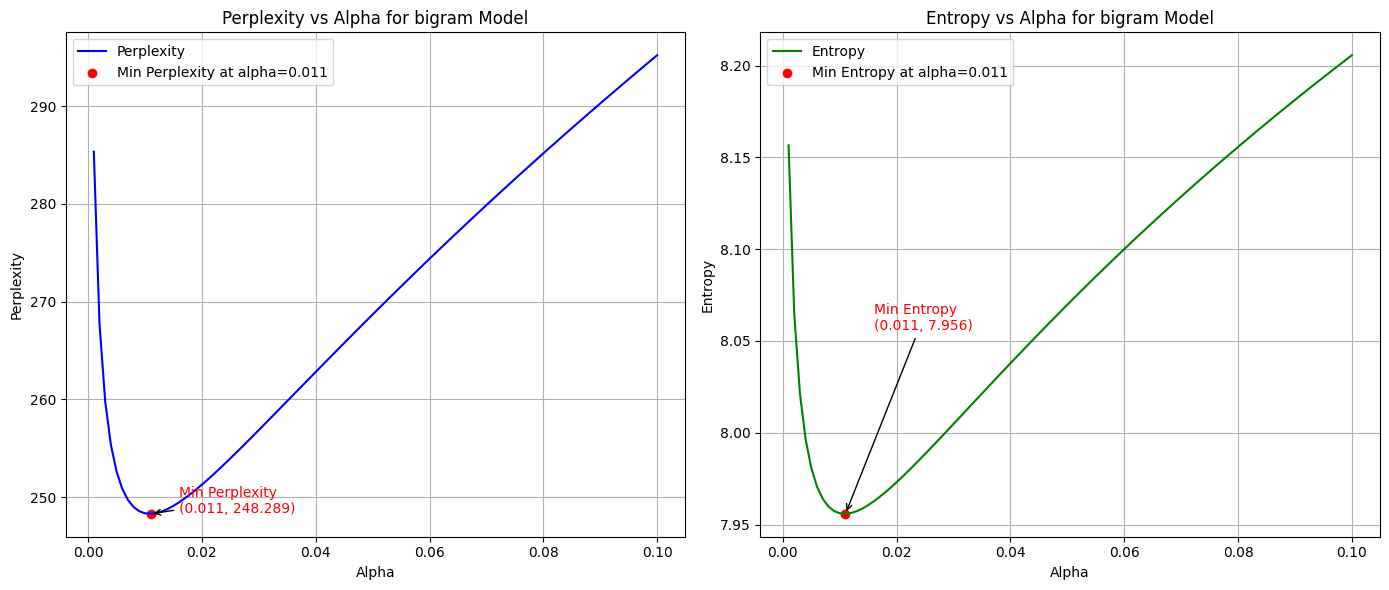

The lowest perplexity/entropy for the trigram model: 979.152 / 9.935 at alpha = 0.004


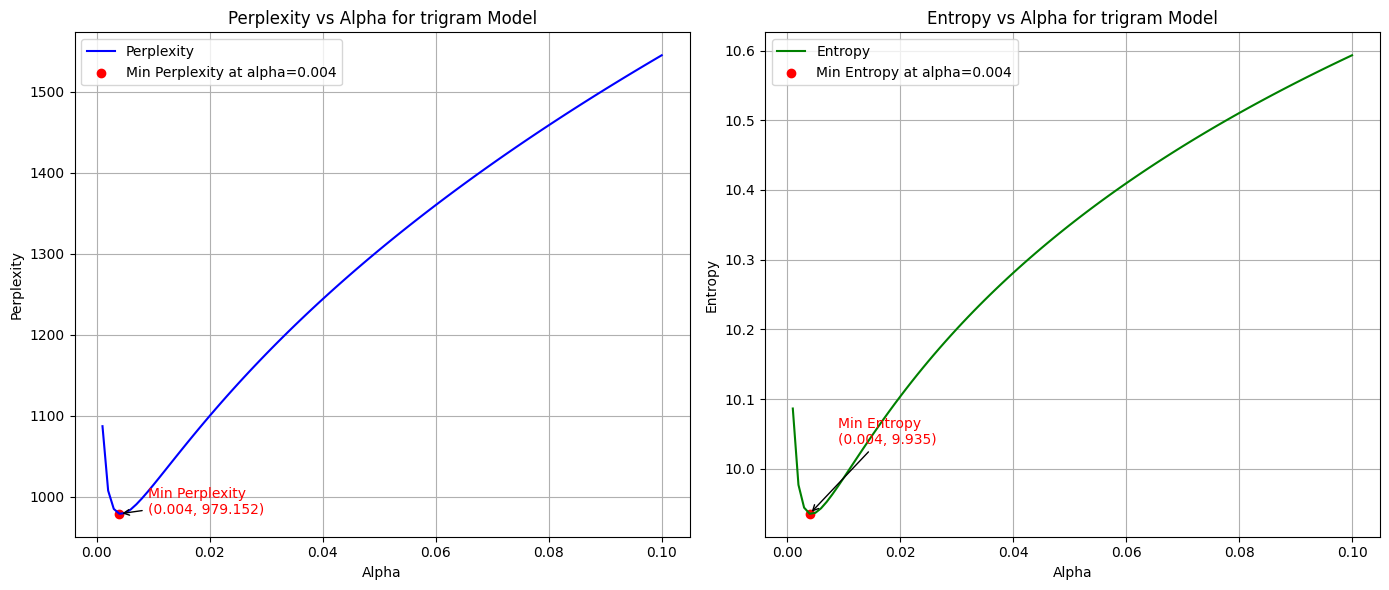

In [22]:
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt

def calc_bigram_prob(w1, w2, alpha, bigram_counts, unigram_counts, vocab_size):
    """ Calculate Bigram model probability using Laplace smoothing. """
    return (bigram_counts[(w1, w2)] + alpha) / (unigram_counts[(w1,)] + alpha * vocab_size)

def calc_trigram_prob(w1, w2, w3, alpha, trigram_counts, bigram_counts, vocab_size):
    """ Calculate Trigram model probability using Laplace smoothing. """
    return (trigram_counts[(w1, w2, w3)] + alpha) / (bigram_counts[(w1, w2)] + alpha * vocab_size)

def calc_ngram_prob(model, *words, alpha, ngram_counts, context_counts, vocab_size):
    """ Calculate n-gram model probability based on the specified model type (bigram/trigram). """
    if model == 'bigram':
        return calc_bigram_prob(words[0], words[1], alpha, ngram_counts, context_counts, vocab_size)
    elif model == 'trigram':
        return calc_trigram_prob(words[0], words[1], words[2], alpha, ngram_counts, context_counts, vocab_size)

def calculate_perplexity_and_entropy(model, dev_corpus, bigram_counts, trigram_counts, unigram_counts, vocab_size):
    """ Calculate perplexity and entropy for the given model type (bigram/trigram) with smoothing parameter alpha. """
    alphas = np.linspace(0.001, 0.1, 100)
    min_perplexity = float('inf')
    min_entropy = float('inf')
    optimal_alpha = None

    perplexities = []  # Store perplexities for plotting
    entropies = []  # Store entropies for plotting

    # Loop through different alpha values for smoothing
    for alpha in alphas:
        log_prob_sum = 0
        ngram_count = 0

        # Evaluate the model over the development corpus
        for sentence in dev_corpus:
            sentence = ['<s>'] + sentence + ['<e>']  # Add start and end tokens
            for idx in range(1, len(sentence)):
                if model == 'bigram':
                    ngram_prob = calc_ngram_prob(model, sentence[idx-1], sentence[idx], alpha=alpha,
                                                 ngram_counts=bigram_counts, context_counts=unigram_counts,
                                                 vocab_size=vocab_size)
                elif model == 'trigram' and idx < len(sentence) - 1:
                    ngram_prob = calc_ngram_prob(model, sentence[idx-1], sentence[idx], sentence[idx+1], alpha=alpha,
                                                 ngram_counts=trigram_counts, context_counts=bigram_counts,
                                                 vocab_size=vocab_size)
                log_prob_sum += math.log2(ngram_prob)
                ngram_count += 1

        # Calculate the average entropy and perplexity for this alpha
        avg_entropy = -log_prob_sum / ngram_count
        avg_perplexity = 2 ** avg_entropy

        entropies.append(avg_entropy)
        perplexities.append(avg_perplexity)

        # Track the best alpha based on minimum entropy
        if avg_entropy < min_entropy:
            min_entropy = avg_entropy
            optimal_alpha = alpha
            min_perplexity = avg_perplexity

    return min_perplexity, min_entropy, optimal_alpha, alphas, perplexities, entropies

# Example: dev_corpus, bigram_counts, trigram_counts, unigram_counts, vocab_size are predefined
for model in ['bigram', 'trigram']:
    min_perplexity, min_entropy, best_alpha, alphas, perplexities, entropies = calculate_perplexity_and_entropy(
        model, dev_corpus, bigram_counts, trigram_counts, unigram_counts, vocabulary_length
    )

    print(f"The lowest perplexity/entropy for the {model} model: "
          f"{round(min_perplexity, 3)} / {round(min_entropy, 3)} at alpha = {np.round(best_alpha, 3)}")

    # Plot perplexity and entropy side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Create a 1x2 grid for the plots

    # Plot perplexity
    axes[0].plot(alphas, perplexities, label='Perplexity', color='blue')
    axes[0].scatter(best_alpha, min_perplexity, color='red', label=f'Min Perplexity at alpha={best_alpha:.3f}')
    axes[0].annotate(f'Min Perplexity\n({best_alpha:.3f}, {min_perplexity:.3f})',
                     xy=(best_alpha, min_perplexity),
                     xytext=(best_alpha + 0.005, min_perplexity + 0.1),
                     arrowprops=dict(facecolor='red', arrowstyle="->"),
                     fontsize=10, color='red')
    axes[0].set_title(f"Perplexity vs Alpha for {model} Model")
    axes[0].set_xlabel('Alpha')
    axes[0].set_ylabel('Perplexity')
    axes[0].legend()
    axes[0].grid(True)

    # Plot entropy
    axes[1].plot(alphas, entropies, label='Entropy', color='green')
    axes[1].scatter(best_alpha, min_entropy, color='red', label=f'Min Entropy at alpha={best_alpha:.3f}')
    axes[1].annotate(f'Min Entropy\n({best_alpha:.3f}, {min_entropy:.3f})',
                     xy=(best_alpha, min_entropy),
                     xytext=(best_alpha + 0.005, min_entropy + 0.1),
                     arrowprops=dict(facecolor='red', arrowstyle="->"),
                     fontsize=10, color='red')
    axes[1].set_title(f"Entropy vs Alpha for {model} Model")
    axes[1].set_xlabel('Alpha')
    axes[1].set_ylabel('Entropy')
    axes[1].legend()
    axes[1].grid(True)

    # Display the plots side by side
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


## Why Do We Compute the Sum of Logarithms of N-gram Probabilities?

In n-gram language models, probabilities are often very small, especially for longer sequences. Instead of directly multiplying these probabilities, we compute the **sum of logarithms** of the probabilities. Here's why this approach is used and why it is important.

### 1. **Small Probabilities**

In typical n-gram models, the probability of a sequence of words is calculated by multiplying the probabilities of individual n-grams. For example, the probability of a sequence like "the market is rising" might be computed as:

$$
P(\text{"the"}) = 0.1, \quad P(\text{"market" | the}) = 0.05, \quad \dots
$$

Multiplying these small probabilities together yields an extremely small number, which can cause **numerical underflow** (i.e., the result becomes too small to represent in a computer).

### 2. **Logarithms for Numerical Stability**

To avoid underflow and to handle very small numbers efficiently, we use **logarithms**. Logarithms have the following useful property:

$$
\log(P(w_1, w_2, \dots, w_n)) = \log(P(w_1)) + \log(P(w_2 | w_1)) + \dots + \log(P(w_n | w_1, \dots, w_{n-1}))
$$

By applying the logarithm, we transform the **product of probabilities** into a **sum of logarithms**. This makes it easier to work with small values and avoids the numerical problems associated with multiplying many small numbers.

### 3. **Simplification of Calculations**

- **Logarithms** simplify the model's calculations by turning a **multiplicative** process into an **additive** one.
- The logarithm of any probability is always **negative** (since probabilities are between 0 and 1), but the sum of these logarithms can be handled much more easily.

This transformation allows us to compute the **log-likelihood** of a sequence efficiently. For example, the log-likelihood of a sequence $( w_1, w_2, \dots, w_n )$ is given by:

$$
\text{log-likelihood} = \sum_{i=1}^{n} \log P(w_i | w_{i-1}, \dots, w_1)
$$

Maximizing the log-likelihood is equivalent to maximizing the likelihood but is much easier to compute.

### 4. **Log-Likelihood Maximization**

Maximizing the likelihood of a sequence is essential in language modeling, and using logarithms makes this process more computationally feasible. The sum of logarithms allows for easier **optimization**, particularly when using **maximum likelihood estimation (MLE)**.

### 5. **Explanation of Kneser-Ney Smoothing**
- **Kneser-Ney smoothing** is a technique used to adjust the probabilities of n-grams, especially for those that have never been seen in the training corpus. It reduces the impact of unseen n-grams by distributing probability mass to less frequent n-grams, thus making the model more robust to rare events.
- The function first calculates the raw frequency of n-grams, then applies the smoothing technique by modifying the counts of n-grams based on their lower-order counterparts.

These functions help in building a language model by counting the frequency of n-grams and applying smoothing to handle unseen combinations of words.